In [53]:
################ Look For #TODOs !!

<IPython.core.display.Javascript object>

In [26]:
import pandas as pd
import numpy as np
import collections as c
import sklearn

from sklearn.preprocessing import MultiLabelBinarizer
import category_encoders as ce
from sklearn import preprocessing

# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel

# example of auto-sklearn for a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from autosklearn.classification import AutoSklearnClassifier
import autosklearn

import copy
import time
import pickle
import itertools
from typing import List
import datetime

# pip install nb_black
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
def get_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col].isna())]

<IPython.core.display.Javascript object>

In [3]:
def print_null_columns(df: pd.DataFrame):
    print("Null Columns and Counts:")
    for col in get_null_columns(df):
        print(">", col, "Null Count:", np.sum(df[col].isna()))

<IPython.core.display.Javascript object>

In [4]:
def type_separator(df: pd.DataFrame, print_results=True):
    set_separator = {}
    for col in df.columns:

        if type(df[col].dtype) == pd.CategoricalDtype:
            a = "cat"
        else:
            a = {
                np.dtype("object"): "cat",
                np.dtype("int"): "numerical",
                np.dtype("int32"): "numerical",
                np.dtype("int64"): "numerical",
                np.dtype("uint8"): "numerical",
                np.dtype("float"): "numerical",
            }[df[col].dtype]

        if a in list(set_separator.keys()):
            set_separator[a].append(col)
        else:
            set_separator[a] = [col]

    if print_results:
        for key, val in set_separator.items():
            print("type:", key, "columns:")
            for col in sorted(val):
                print(">", col)
            print("-" * 32)
        return None
    return set_separator

<IPython.core.display.Javascript object>

In [109]:
# Read Data
df = pd.read_csv("interim_data/df_completed_1_2_3_with_mv.csv")
# df = pd.read_csv("interim_data/df_completed_1_2_3.csv")

id_columns = ["CUSTOMER", "TEST_SET_ID", "IDX_CUSTOMER"]
unnecessary_reduced_cols = [
    "OFFER_TYPE_REDUCED_1",
    "OFFER_TYPE_REDUCED_2",
    "SALES_OFFICE_REDUCED",
]

to_be_dropped_cols = id_columns + unnecessary_reduced_cols
df = df.drop(to_be_dropped_cols, axis=1)


# df["OFFER_STATUS"] = df["OFFER_STATUS"].astype(np.dtype("int"))
# new columns
df["ADDITIONAL_COST"] = df["OFFER_PRICE"] - df["MATERIAL_COST"] - df["SERVICE_COST"]
df["TOTAL_COST"] = df["MATERIAL_COST"] + df["SERVICE_COST"]

###################

type_to_col = type_separator(df, print_results=False)
for col in type_to_col["cat"]:
    num_unq = len(df[col].unique())
    trimmed_col = col.strip().replace(" ", "_")
    if num_unq < 5:
        # print(f"[INFO] Col:{col},num_of_unq:{num_unq}, applying 1-HOT encoding.")
        onehot_df = pd.get_dummies(df[col])
        onehot_df = onehot_df.add_prefix(trimmed_col + "_1HOTENC_")
        df = pd.concat((df, onehot_df), axis=1)
    elif num_unq >= 5:
        # print(f"[INFO] Col:{col},num_of_unq:{num_unq}, applying BINARY encoding.")
        encoder = ce.BinaryEncoder(cols=[col])
        binenc_df = encoder.fit_transform(df[[col]])
        binenc_df.columns = [
            f"{trimmed_col}_BINENC_{i}" for i in range(len(binenc_df.columns))
        ]
        df = pd.concat((df, binenc_df), axis=1)

for col in type_separator(df, print_results=False)["cat"]:
    df[col] = pd.Categorical(df[col])

##########################

###### ADDITIONAL < FEATURES - START
add_less_than_features = True
print("[IMPORTANT] Adding Less Than Features:", add_less_than_features)

if add_less_than_features:
    raw_numeric_cols = [
        a
        for a in type_separator(df, print_results=False)["numerical"]
        if not any(
            x in a
            for x in [
                "OFFER_STATUS",
                "IS_NA",
                "HAS_",
                "1HOTENC",
                "BINENC",
                "IS_",
                "_LOG",
            ]
        )
    ]

    raw_numeric_cols_2_combinations = list(
        itertools.combinations(raw_numeric_cols, r=2)
    )
    new_less_than_cols = []
    for col1, col2 in raw_numeric_cols_2_combinations:
        new_col = np.where(
            np.isnan(df[col1]) | np.isnan(df[col2]), np.nan, (df[col1] < df[col2])
        )
        name_of_new_col = col1 + "_<_" + col2

        if len(np.unique(new_col[~np.isnan(new_col)])) > 1:  # Not all values are 1 or 0
            new_less_than_cols.append(pd.Series(new_col, name=name_of_new_col))
            # print(f'[INFO] Added new "less than" column: "{name_of_new_col}".')
        else:
            pass  # print(f'[INFO] NOT added "Less Then" column: "{name_of_new_col}".')

    df = pd.concat([df, pd.concat(new_less_than_cols, axis=1)], axis=1)

[IMPORTANT] Adding Less Than Features: True


<IPython.core.display.Javascript object>

In [110]:
############# DROPPP -START
drop_cols = [
    ############## Correlation are same or very similar
    "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Privately Owned/Publicly Traded",
    "OWNERSHIP_NA_AS_NO_INFO_REDUCED_1HOTENC_Privately Owned/Publicly Traded",
    "OWNERSHIP_NO_INFO_AS_NA_1HOTENC_Privately Owned/Publicly Traded",
    "OWNERSHIP_NO_INFO_AS_NA_REDUCED_1HOTENC_Privately Owned/Publicly Traded",
    "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Individual Person",
    "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Governmental",
    "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_No information",
    "OWNERSHIP_NO_INFO_AS_NA_REDUCED_1HOTENC_NOT_GIVEN",
    "OWNERSHIP_NO_INFO_AS_NA_1HOTENC_NOT_GIVEN",
    "OWNERSHIP_REDUCED_1HOTENC_NOT_GIVEN",
    "TECH_REDUCED_2_IS_F",
    "TECH_BINENC_0",
    "SINCE_CREATION_YEAR_<_REV_PERCENTAGE_INCREASE_NO_OUTLIER",  # (34, False)
    ############## Experimentally
    "TOTAL_COSTS_PRODUCT_LOG",
    ## Boruta Results
    #'HAS_COSTS_PRODUCT_C' , # (11, False)
    #'SALES_LOCATION_BINENC_2' , # (11, False)
    #'SALES_LOCATION_BINENC_5' , # (11, False)
    #'SALES_OFFICE_BINENC_5' , # (11, False)
    #'PRICE_LIST_1HOTENC_CMT End Customer' , # (13, False)
    #'CURRENCY_BINENC_1' , # (15, False)
    #'HAS_COSTS_PRODUCT_E' , # (15, False)
    #'CURRENCY_BINENC_2' , # (17, False)
    #'SALES_LOCATION_BINENC_0' , # (17, False)
    #'SALES_OFFICE_BINENC_0' , # (17, False)
    "CURRENCY_BINENC_0",  # (19, False)
    "OWNERSHIP_BINENC_0",  # (20, False)
    "OWNERSHIP_NO_INFO_AS_NA_1HOTENC_Individual Person",  # (21, False)
    "IS_NA_SALES_LOCATION",  # (22, False)
    "IS_NA_SALES_OFFICE",  # (23, False)
    ## From XGB Feature Importance
    # "OFFER_PRICE_<_REV_PERCENTAGE_INCREASE",  # 0.03901156038045883
    # "REV_PERCENTAGE_INCREASE_<_TOTAL_COST",  # 0.03355308994650841
    # "SINCE_CREATION_YEAR_<_SO_CREATED_DATE_SCALED",  # 0.028346635401248932
    # "SERVICE_LIST_PRICE_<_SERVICE_COST",  # 0.020826183259487152
    # "SERVICE_COST_<_REV_CURRENT_YEAR.1",  # 0.011560462415218353
    # "MATERIAL_COST_<_REV_CURRENT_YEAR.1",  # 0.008442980237305164
    # "SERVICE_LIST_PRICE_<_REV_CURRENT_YEAR.1",  # 0.00834011472761631
    # "REV_CURRENT_YEAR.2_<_TOTAL_COST",  # 0.007833493873476982
    # "TOTAL_COSTS_PRODUCT_<_SO_CREATED_DATE_SCALED",  # 0.007648177444934845
    # "SERVICE_LIST_PRICE_<_TOTAL_COST",  # 0.007083372678607702
    # "SERVICE_LIST_PRICE_<_REV_PERCENTAGE_INCREASE",  # 0.007078474387526512
    # "SERVICE_LIST_PRICE_<_ADDITIONAL_COST",  # 0.007031504064798355
    # "MATERIAL_COST_<_ADDITIONAL_COST",  # 0.0062048910185694695
    # "REV_PERCENTAGE_INCREASE_<_ADDITIONAL_COST",  # 0.005901111755520105
    # "OFFER_PRICE_<_REV_CURRENT_YEAR.1",  # 0.005844731815159321
    # "REV_CURRENT_YEAR.1_<_ADDITIONAL_COST",  # 0.005387913901358843
    # "MATERIAL_COST_<_REV_PERCENTAGE_INCREASE",  # 0.0052901399321854115
    # "REV_PERCENTAGE_INCREASE_<_SO_CREATED_DATE_SCALED",  # 0.005108097568154335
    # "SO_CREATED_DATE_SCALED_<_REV_PERCENTAGE_INCREASE_NO_OUTLIER",  # 0.005060083232820034
    # "REV_CURRENT_YEAR.2_<_ADDITIONAL_COST",  # 0.004588569980114698
    # "MATERIAL_COST_<_SERVICE_COST",  # 0.004372822120785713
    # "SERVICE_COST_<_ADDITIONAL_COST",  # 0.004095220938324928
    # "SERVICE_COST_<_REV_PERCENTAGE_INCREASE",  # 0.003644987242296338
    # "SERVICE_COST_<_REV_CURRENT_YEAR.2",  # 0.0022056959569454193
    "SERVICE_COST_<_CREATION_YEAR",  # 0.0
    "REV_CURRENT_YEAR.1_<_REV_PERCENTAGE_INCREASE",  # 0.0
    "CREATION_YEAR_<_TOTAL_COST",  # 0.0
    "CREATION_YEAR_<_REV_PERCENTAGE_INCREASE",  # 0.0
    "CREATION_YEAR_<_ADDITIONAL_COST",  # 0.0
]

for col in drop_cols:
    if col in list(df.columns):
        print("[INFO] Dropped:", col)
        df = df.drop(col, axis=1)

[INFO] Dropped: OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Privately Owned/Publicly Traded
[INFO] Dropped: OWNERSHIP_NA_AS_NO_INFO_REDUCED_1HOTENC_Privately Owned/Publicly Traded
[INFO] Dropped: OWNERSHIP_NO_INFO_AS_NA_1HOTENC_Privately Owned/Publicly Traded
[INFO] Dropped: OWNERSHIP_NO_INFO_AS_NA_REDUCED_1HOTENC_Privately Owned/Publicly Traded
[INFO] Dropped: OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Individual Person
[INFO] Dropped: OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Governmental
[INFO] Dropped: OWNERSHIP_NA_AS_NO_INFO_1HOTENC_No information
[INFO] Dropped: TECH_REDUCED_2_IS_F
[INFO] Dropped: TECH_BINENC_0
[INFO] Dropped: SINCE_CREATION_YEAR_<_REV_PERCENTAGE_INCREASE_NO_OUTLIER
[INFO] Dropped: TOTAL_COSTS_PRODUCT_LOG
[INFO] Dropped: CURRENCY_BINENC_0
[INFO] Dropped: OWNERSHIP_BINENC_0
[INFO] Dropped: OWNERSHIP_NO_INFO_AS_NA_1HOTENC_Individual Person
[INFO] Dropped: IS_NA_SALES_LOCATION
[INFO] Dropped: IS_NA_SALES_OFFICE
[INFO] Dropped: SERVICE_COST_<_CREATION_YEAR
[INFO] Dropped: REV_CURRENT_YEAR.1_<_REV_PE

<IPython.core.display.Javascript object>

In [111]:
look_at_feature_importance = False
if look_at_feature_importance:
    ############################################## FEATURE IMPORTANCE INTERVENTION - START
    from boruta import BorutaPy
    from sklearn.ensemble import RandomForestClassifier

    df_new = df[~np.isnan(df["OFFER_STATUS"])].copy()
    columns_to_be_dropped = get_null_columns(df_new)
    if "cat" in type_separator(df_new, False):
        columns_to_be_dropped += [
            col for col in type_separator(df_new, False)["cat"] if col in df_new.columns
        ]
    columns_to_be_dropped = set(columns_to_be_dropped)
    if "OFFER_STATUS" in columns_to_be_dropped:
        columns_to_be_dropped.remove("OFFER_STATUS")

    df_new = df_new.drop(columns_to_be_dropped, axis=1)
    X, y = df_new.drop("OFFER_STATUS", axis=1), df_new["OFFER_STATUS"]

    # define random forest classifier
    forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
    forest.fit(X, y)

    # define Boruta feature selection method
    feat_selector = BorutaPy(
        forest,
        # n_jobs=-1,
        # class_weight="balanced",
        n_estimators="auto",
        verbose=2,
        random_state=42,
    )

    # find all relevant features
    feat_selector.fit(X.to_numpy(), y.to_numpy())

    # check selected features
    print(feat_selector.support_)

    # check ranking of features
    print(feat_selector.ranking_)

    # check selected features

    a = list(
        zip(list(feat_selector.ranking_), list(feat_selector.support_), list(X.columns))
    )

    for item in sorted(a):
        print(item, ",")
    ############################################## FEATURE IMPORTANCE INTERVENTION - STOP

<IPython.core.display.Javascript object>

In [122]:
predict_final = True
if predict_final:
    df_tmp = pd.read_csv("interim_data/df_completed_1_2_3_with_mv.csv")
    test_set_id_col = df_tmp[np.isnan(df_tmp["OFFER_STATUS"])]["TEST_SET_ID"]

    ## Predict BREAK - start
    real_test = df[np.isnan(df["OFFER_STATUS"])]
    real_test["prediction"] = model2.predict(real_test)
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    real_test["id"] = real_test["id"].astype(int)

    ## Predict BREAK - stop

/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/autosklearn/data/feature_validator.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category')
/tmp/ipykernel_227940/3260068050.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test["prediction"] = model2.predict(real_test)


<IPython.core.display.Javascript object>

In [124]:
real_test["prediction"].value_counts()

1.0    1880
0.0     696
Name: prediction, dtype: int64

<IPython.core.display.Javascript object>

In [125]:
real_test.to_csv("predictions_versed_chimpanzee_3.csv", header=True, index=False)

<IPython.core.display.Javascript object>

In [106]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.classification import AutoSklearnClassifier

df = df[~np.isnan(df["OFFER_STATUS"])]
# Col Selection & Conversion
X, y = df.drop("OFFER_STATUS", axis=1), df["OFFER_STATUS"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33, random_state=42
)

<IPython.core.display.Javascript object>

In [108]:
model2 = AutoSklearnClassifier(
    time_left_for_this_task=20 * 60,
    # time_left_for_this_task=60,
    seed=42,
    per_run_time_limit=30,
    n_jobs=-1,
    metric=autosklearn.metrics.balanced_accuracy,
    resampling_strategy="cv",
    resampling_strategy_arguments={"cv": {"folds": 10}, "shuffle": True},
    # resampling_strategy_arguments={"cv": {"folds": 10}, "shuffle": True},
    # resampling_strategy_arguments={"train_size": 0.67, "shuffle": True},
    # include={"svm"}, ## TODO: Consider including only relevant algorithms or excluding irrelevant ones
)

start = time.time()
model2.fit(X_train, y_train)
end = time.time()
y_hat = model2.predict(X_test)

# print(model2.sprint_statistics())
# print(model2.best_val_acc)
best_val_score_here = float(model2.sprint_statistics().split("\n")[3][25:])
print(model2.get_models_with_weights())
# model2.leaderboard()

# Evaluate
val_acc = balanced_accuracy_score(y_true=y_test, y_pred=y_hat)
print("Elapsed Time:", end - start)
# print("Dropped until:", col)
print("Best Val Score:", best_val_score_here)
print("Final BAC Score: %.3f" % val_acc)

# Pickle
if not (("best_val_acc" in vars() or "best_val_acc" in globals())):
    best_val_acc = val_acc
file_name = f"model_pickles/model_{int(val_acc*10**3)}" + str(
    datetime.datetime.now()
).replace(" ", "_")
if val_acc >= best_val_acc:
    with open(file_name, "wb") as f:
        pickle.dump(model2, f)
else:
    with open(file_name, "wb") as f:
        pickle.dump(model2, f)

print("=" * 32)

/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37509 instead
  warnings.warn(
/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be r

[(0.42, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'sgd', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'random_trees_embedding', 'classifier:sgd:alpha': 6.661096438196758e-05, 'classifier:sgd:average': 'False', 'classifier:sgd:fit_intercept': 'True', 'classifier:sgd:learning_rate': 'invscaling', 'classifier:sgd:loss': 'perceptron', 'classifier:sgd:penalty': 'l2', 'classifier:sgd:tol': 2.0428856355579325e-05, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:random_trees_embedding:bootstrap': 'False', 'feature_preprocessor:random_trees_embedding:max_depth

<IPython.core.display.Javascript object>

In [ ]:
# Last
Best Val Score: 0.720913
Final BAC Score: 0.709

In [ ]:
Best Val Score: 0.722002
Final BAC Score: 0.713

In [ ]:

Without less than features:
Best Val Score: 0.723375
Final BAC Score: 0.712

In [ ]:
With all less than features

Best Val Score: 0.722037
Final BAC Score: 0.718

## trying svM

13878    0.0
5495     1.0
23314    1.0
5442     0.0
1757     1.0
        ... 
4828     1.0
14194    1.0
21599    1.0
25380    1.0
3923     1.0
Name: OFFER_STATUS, Length: 18860, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
bla_col = type_separator(X_train, False)["numerical"]

# Import svm model
from sklearn import svm

del clf

# Create a svm Classifier
clf = svm.SVC(kernel="linear")  # Linear Kernel

# Train the model using the training sets
clf.fit(
    X_train[bla_col][2000:4000],
    pd.DataFrame(y_train)[2000:4000]["OFFER_STATUS"],
)


# Predict the response for test dataset
y_pred2 = clf.predict(X_test[bla_col])

# Evaluate
print(
    "SVM, Final BAC Score: %.3f"
    % balanced_accuracy_score(y_true=y_test, y_pred=y_pred2)
)
np.unique(y_pred2)

In [108]:
np.all(y_pred2 == y_pred)

False

<IPython.core.display.Javascript object>

In [26]:
np.isnan(df[col1]).value_counts()

False    20785
True      2790
Name: REV_CURRENT_YEAR_LOG.1, dtype: int64

In [11]:
y_pred = clf.predict(X_test[type_separator(X_test, False)["numerical"][0:10]][:100])

<IPython.core.display.Javascript object>

## something else

'REV_PERCENTAGE_INCREASE_>_REV_CURRENT_YEAR.2',	#0.09610101580619812
'TOTAL_COST_>_REV_CURRENT_YEAR.1',	#0.06857892870903015
'TECH_REDUCED_1_1HOTENC_F',	#0.05166756734251976
'PRICE_LIST_1HOTENC_CMT Installer',	#0.04839813709259033
'REV_PERCENTAGE_INCREASE_>_OFFER_PRICE',	#0.03901156038045883
'TOTAL_COST_>_REV_PERCENTAGE_INCREASE',	#0.03355308994650841
'TECH_REDUCED_1_1HOTENC_E_EPS_FP_BP',	#0.029259905219078064
'SO_CREATED_DATE_SCALED_>_SINCE_CREATION_YEAR',	#0.028346635401248932
'OWNERSHIP_REDUCED_1HOTENC_Governmental_IndividualPerson_Noinformation',	#0.021181341260671616
'SERVICE_COST_>_SERVICE_LIST_PRICE',	#0.020826183259487152
'OFFER_TYPE_BINENC_0',	#0.01599985547363758
'BUSINESS_TYPE_BINENC_2',	#0.015860842540860176
'OFFER_TYPE_BINENC_1',	#0.01535513624548912
'REV_CURRENT_YEAR_LOG.1',	#0.014912281185388565
'BUSINESS_TYPE_BINENC_3',	#0.014111315831542015
'BUSINESS_TYPE_BINENC_1',	#0.014050492085516453
'BUSINESS_TYPE_BINENC_0',	#0.012201179750263691
'REV_CURRENT_YEAR.1_>_SERVICE_COST

<IPython.core.display.Javascript object>

In [23]:
model.feature_importances_

array([0.00483483, 0.00622169, 0.00612488, 0.00827248, 0.00614797,
       0.00542583, 0.00580322, 0.00563305, 0.0069987 , 0.00652553,
       0.00526524, 0.00677991, 0.00565498, 0.01072893, 0.00422701,
       0.00544071, 0.        , 0.00640589, 0.0075346 , 0.        ,
       0.        , 0.        , 0.        , 0.01491228, 0.00752625,
       0.        , 0.00242507, 0.00877993, 0.        , 0.00375137,
       0.        , 0.00525699, 0.0053093 , 0.00775364, 0.04839814,
       0.01103497, 0.        , 0.00916751, 0.00566818, 0.01599986,
       0.01535514, 0.0078363 , 0.00516298, 0.00977354, 0.01220118,
       0.01405049, 0.01586084, 0.01411132, 0.00612613, 0.01057226,
       0.00875082, 0.00810502, 0.00660104, 0.00673483, 0.00776427,
       0.00695844, 0.00632743, 0.00791174, 0.00723181, 0.00647956,
       0.00311969, 0.        , 0.00415937, 0.00485779, 0.01107655,
       0.00759826, 0.02925991, 0.05166757, 0.00372083, 0.00494266,
       0.00535171, 0.02118134, 0.        , 0.00584473, 0.03901

<IPython.core.display.Javascript object>

/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/iceking/Desktop/TUM Lecture Docs/3. Business Analytics and Machine Learning (IN2028)/Analytics Cup/Project Files/venv/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:55:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


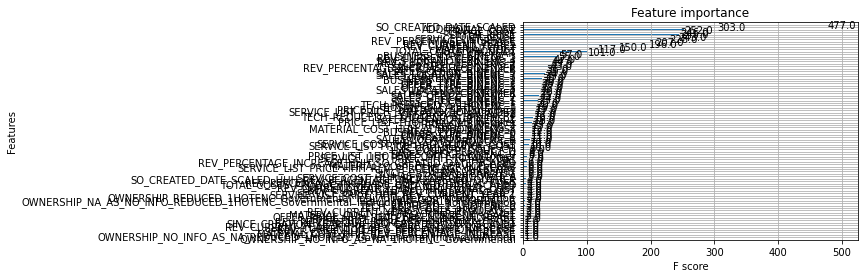

<IPython.core.display.Javascript object>

In [12]:
# ndians dataset using the built-in plot_importance() function.
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# load data
# dataset = loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split data into X and y
# X = dataset[:, 0:8]
# y = dataset[:, 8]
# fit model no training data
model = XGBClassifier()
aa = X_train[type_separator(X_train, False)["numerical"]]

aa.columns = [xyz.replace("<", "HHH") for xyz in aa.columns]

model.fit(aa, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

In [13]:
aa.columns = [xyz.replace("HHH", "<") for xyz in aa.columns]

a = list(zip(list(model.feature_importances_), list(aa.columns)))


for item in sorted(a)[::-1]:
    print(f"'{item[1]}',\t#{item[0]}")

'REV_CURRENT_YEAR.2_<_REV_PERCENTAGE_INCREASE',	#0.09610101580619812
'REV_CURRENT_YEAR.1_<_TOTAL_COST',	#0.06857892870903015
'TECH_REDUCED_1_1HOTENC_F',	#0.05166756734251976
'PRICE_LIST_1HOTENC_CMT Installer',	#0.04839813709259033
'OFFER_PRICE_<_REV_PERCENTAGE_INCREASE',	#0.03901156038045883
'REV_PERCENTAGE_INCREASE_<_TOTAL_COST',	#0.03355308994650841
'TECH_REDUCED_1_1HOTENC_E_EPS_FP_BP',	#0.029259905219078064
'SINCE_CREATION_YEAR_<_SO_CREATED_DATE_SCALED',	#0.028346635401248932
'OWNERSHIP_REDUCED_1HOTENC_Governmental_IndividualPerson_Noinformation',	#0.021181341260671616
'SERVICE_LIST_PRICE_<_SERVICE_COST',	#0.020826183259487152
'OFFER_TYPE_BINENC_0',	#0.01599985547363758
'BUSINESS_TYPE_BINENC_2',	#0.015860842540860176
'OFFER_TYPE_BINENC_1',	#0.01535513624548912
'REV_CURRENT_YEAR_LOG.1',	#0.014912281185388565
'BUSINESS_TYPE_BINENC_3',	#0.014111315831542015
'BUSINESS_TYPE_BINENC_1',	#0.014050492085516453
'BUSINESS_TYPE_BINENC_0',	#0.012201179750263691
'SERVICE_COST_<_REV_CURRENT_YEAR.1

<IPython.core.display.Javascript object>